# Run

In [1]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
import time
import os
import scipy
from scipy import signal
from scipy.signal import find_peaks
import librosa
import pickle

In [2]:
with open('Udata.pkl', 'rb') as file:
    Udata = pickle.load(file)

# Vamos remover a atividade 'jumping'
actis = ['climbingdown', 'climbingup', 'lying', 'running', 'sitting', 'standing', 'walking']
posis = ['chest', 'forearm', 'head', 'shin', 'thigh', 'upperarm', 'waist']
users = ['proband' + x for x in np.arange(1,16).astype(str)]
# proband2 não tem acc_climbingup_forearm
users.remove('proband2')
# Vamos remover usuários com menos de 21000 amostras
users.remove('proband1')
users.remove('proband4')
users.remove('proband7')
users.remove('proband14')

In [3]:
def predlin(Xtr):
    X = Xtr[:,:-1]
    y = Xtr[:,-1]
    # w = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(y)
    w = np.linalg.pinv(X).dot(y)    
    return w

In [4]:
def picotar(x, J, passo):
    N = x.shape[0]
    Nj = (N-J)//passo + 1
    X = np.zeros((Nj, J))
    for i in range(Nj):
        X[i,:] = x[(i*passo):(i*passo+J)]
    return X

# Exps iniciais

In [7]:
nu = 0
nd = 0
na = 3
fs = 50
passo = 1
J = 150
sig = np.array(Udata[nu][nd])[na, :, 0]
x = sig[1000:1150]
px.line(sig)

In [8]:
px.line(x)

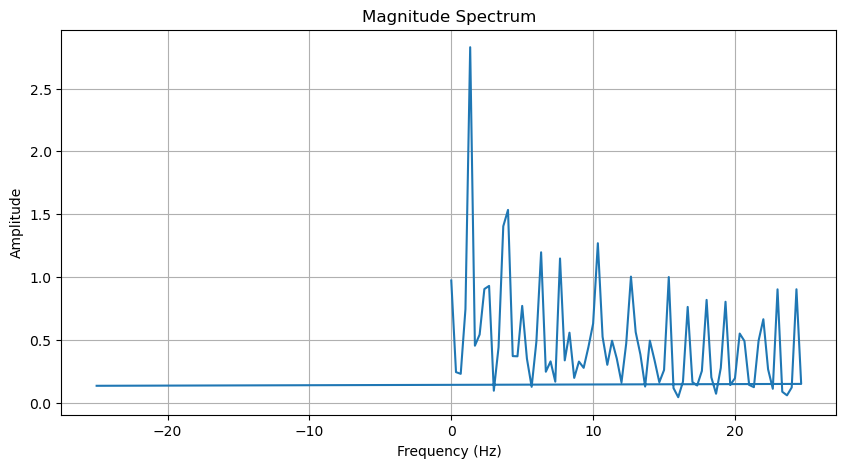

Peak 1: Frequency = 1.33 Hz, Amplitude = 2.829, Bandwidth ≈ 0.67 Hz
Peak 2: Frequency = 2.67 Hz, Amplitude = 0.930, Bandwidth ≈ 1.00 Hz
Peak 3: Frequency = 4.00 Hz, Amplitude = 1.534, Bandwidth ≈ 1.00 Hz
Peak 4: Frequency = 5.00 Hz, Amplitude = 0.771, Bandwidth ≈ 0.67 Hz
Peak 5: Frequency = 6.33 Hz, Amplitude = 1.197, Bandwidth ≈ 0.67 Hz
Peak 6: Frequency = 7.00 Hz, Amplitude = 0.329, Bandwidth ≈ 1.67 Hz
Peak 7: Frequency = 7.67 Hz, Amplitude = 1.148, Bandwidth ≈ 0.67 Hz
Peak 8: Frequency = 8.33 Hz, Amplitude = 0.558, Bandwidth ≈ 0.67 Hz
Peak 9: Frequency = 9.00 Hz, Amplitude = 0.328, Bandwidth ≈ 3.33 Hz
Peak 10: Frequency = 10.33 Hz, Amplitude = 1.269, Bandwidth ≈ 0.67 Hz
Peak 11: Frequency = 11.33 Hz, Amplitude = 0.494, Bandwidth ≈ 1.00 Hz
Peak 12: Frequency = 12.67 Hz, Amplitude = 1.004, Bandwidth ≈ 0.67 Hz
Peak 13: Frequency = 14.00 Hz, Amplitude = 0.494, Bandwidth ≈ 0.67 Hz
Peak 14: Frequency = 15.33 Hz, Amplitude = 1.000, Bandwidth ≈ 0.67 Hz
Peak 15: Frequency = 16.67 Hz, Amplitu

In [9]:
N = 150                # Number of samples
T = N / fs             # Total duration
t = np.arange(N) / fs  # Time vector

# Example signal: fundamental + 2 overtones
# x = (np.sin(2*np.pi*5*t) +          # Fundamental at 5 Hz
#      0.5*np.sin(2*np.pi*10*t) +     # First overtone
#      0.25*np.sin(2*np.pi*15*t))     # Second overtone

# FFT
X = np.fft.fft(x)
f = np.fft.fftfreq(N, 1/fs)
X_half = X[:N//2 + 1]
f_half = f[:N//2 + 1]

# Amplitude spectrum (normalized)
A = np.abs(X_half) / N
A[1:-1] *= 2

# Plot magnitude spectrum
plt.figure(figsize=(10, 5))
plt.plot(f_half, A)
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Peak detection
threshold = 0.05  # Adjust as needed
peaks, _ = find_peaks(A, height=threshold)
peak_freqs = f_half[peaks]
peak_amps = A[peaks]

# Estimate 3-dB bandwidths (simple method)
bandwidths = []
for i, peak_idx in enumerate(peaks):
    amp = A[peak_idx]
    half_power = amp * 0.7071

    # Search left
    left = peak_idx
    while left > 0 and A[left] > half_power:
        left -= 1

    # Search right
    right = peak_idx
    while right < len(A) - 1 and A[right] > half_power:
        right += 1

    bw = f_half[right] - f_half[left]
    bandwidths.append(bw)

# Print results
for i, freq in enumerate(peak_freqs):
    print(f"Peak {i+1}: Frequency = {freq:.2f} Hz, Amplitude = {peak_amps[i]:.3f}, Bandwidth ≈ {bandwidths[i]:.2f} Hz")
